## 4.5 KNN Classification ipynb file

In [1]:
import os
os.chdir('./../../')
from models.Autoencoders.pca_autoencoder import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
train_data = pd.read_csv('./data/external/fashion_mnist/fashion-mnist_train.csv')  # Update the path as needed
test_data = pd.read_csv('./data/external/fashion_mnist/fashion-mnist_test.csv')    # Update the path as needed

# Separate features and labels
x_train = train_data.drop(columns=['label']).values.reshape(-1, 28, 28)  # Reshape to (num_samples, 28, 28)
y_train = train_data['label'].values

x_test = test_data.drop(columns=['label']).values.reshape(-1, 28, 28)
y_test = test_data['label'].values

# Normalize the images
x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 

# Split the training data into train, val, and test sets (70:10:20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.30, random_state=42)

# Check the shapes of the datasets
print("Training set shape:", x_train.shape, y_train.shape)
print("Validation set shape:", x_val.shape, y_val.shape)
print("Test set shape:", x_test.shape, y_test.shape)

# Flatten the images (28x28 -> 784)
x_train_flattened = x_train.reshape(-1, 28*28)
x_val_flattened = x_val.reshape(-1, 28*28)
x_test_flattened = x_test.reshape(-1, 28*28)

# Normalize pixel values to the range [0, 1]
x_train_flattened /= 255.0
x_val_flattened /= 255.0
x_test_flattened /= 255.0

print(y_test)

Training set shape: (42000, 28, 28) (42000,)
Validation set shape: (18000, 28, 28) (18000,)
Test set shape: (10000, 28, 28) (10000,)
[0 1 2 ... 8 8 1]


## Latenet PCA

In [8]:

# Set the optimal number of components
koptimal = 6

# Assuming x_train and x_val are your training and validation datasets
# Initialize and fit the PCA Autoencoder with koptimal components
pca_autoencoder = PcaAutoencoder(n_components=koptimal)
pca_autoencoder.fit(x_train_flattened)

# Encode the training and validation datasets to get latent features
PCAx_train_encoded = pca_autoencoder.encode(x_train_flattened)
PCAx_test_encoded = pca_autoencoder.encode(x_test_flattened)

print("Latent features (training):", PCAx_train_encoded.shape)
print("Latent features (validation):", PCAx_test_encoded.shape)


Latent features (training): (42000, 6)
Latent features (validation): (10000, 6)


## Latenet CNN autoencoder

In [16]:
from models.Autoencoders.cnn_autoencoder import *


# Data loading pipeline (adjusted to ensure correct shape)
x_train1 = x_train[..., np.newaxis].astype('float32')  # Ensure shape is (batch_size, 28, 28, 1)
x_val1 = x_val[..., np.newaxis].astype('float32') 
x_test1 = x_test[..., np.newaxis].astype('float32') 
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train1).permute(0, 3, 1, 2)  # Convert to (batch_size, 1, 28, 28)
x_val_tensor = torch.tensor(x_val1).permute(0, 3, 1, 2)
x_test_tensor = torch.tensor(x_test1).permute(0, 3, 1, 2)  # Change from (batch_size, 28, 28, 1) to (batch_size, 1, 28, 28)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
val_dataset = TensorDataset(x_val_tensor, x_val_tensor)
test_dataset = TensorDataset(x_test_tensor, x_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Set latent dimension = k_optimal
latent_dim = 6

# Initialize the model
autoencoder = Autoencoder(latent_dim,num_filters=[64,128])   ##used class here

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Train the model using the fit method
autoencoder.fit(train_loader,val_loader, criterion,num_epochs=5)


# Extract latent features for training and validation sets
def extract_latent_features(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    latent_features = []
    with torch.no_grad():
        for data in data_loader:
            img, _ = data
            img = img.to(device)  # Move data to GPU or CPU
            latent = model.encode(img)  # Get the latent representation
            latent_features.append(latent.cpu().numpy())
    return np.concatenate(latent_features, axis=0)  # Combine all latent features

# Get latent features for training and validation sets
CNNtrain_latent_features = extract_latent_features(train_loader, autoencoder)
CNNval_latent_features = extract_latent_features(val_loader, autoencoder)
CNNtest_latent_features = extract_latent_features(test_loader, autoencoder)

print("Training Latent Features Shape:", CNNtrain_latent_features.shape)
print("Validation Latent Features Shape:", CNNtest_latent_features.shape)


Epoch 1/5, Train Loss: 0.0530, Validation Loss: 0.0388
Epoch 2/5, Train Loss: 0.0377, Validation Loss: 0.0367
Epoch 3/5, Train Loss: 0.0358, Validation Loss: 0.0351
Epoch 4/5, Train Loss: 0.0346, Validation Loss: 0.0340
Epoch 5/5, Train Loss: 0.0339, Validation Loss: 0.0334
Training Latent Features Shape: (42000, 6)
Validation Latent Features Shape: (10000, 6)


## Latent MLP autoencoder

In [21]:
from models.AutoEncoders_usingmlp3.AutoEncoders import *

mlp = AutoEncoder(
    input_size=x_train_flattened.shape[1],  # 784, since we flattened the images
    before=[100,70],  # Example of the hidden layers before the latent space
    latent_size=6,   # Latent size
    after=[70,100],    # Example of the hidden layers after the latent space
    output_size=x_train_flattened.shape[1],  # Output should match the input size
    learning_rate=0.001,
    activation='relu',
    optimizer='mini-batch',
    batch_size=10,
    epochs=50
)

# Train the model
mlp.fit(x_train_flattened, x_train_flattened,x_val_flattened)

MLPlatent_reduced_train, _ = mlp.get_latent(x_train_flattened)
MLPlatent_reduced_test, _ = mlp.get_latent(x_test_flattened)

# Print the shape of the reduced latent features
print("Shape of Reduced Training Latent Features:", MLPlatent_reduced_train.shape)
print("Shape of Reduced Validation Latent Features:", MLPlatent_reduced_test.shape)

[784, 100, 70, 6, 70, 100, 784]
Epoch Train 0: Loss = 0.0624
Epoch Val 0: Loss = 0.0621
Epoch Train 10: Loss = 0.0326
Epoch Val 10: Loss = 0.0325
Epoch Train 20: Loss = 0.0273
Epoch Val 20: Loss = 0.0272
Epoch Train 30: Loss = 0.0249
Epoch Val 30: Loss = 0.0248
Epoch Train 40: Loss = 0.0236
Epoch Val 40: Loss = 0.0235
Shape of Reduced Training Latent Features: (42000, 6)
Shape of Reduced Validation Latent Features: (10000, 6)


## 1. obtained all latent features from above

In [24]:
print("PCA")
print("Latent features (training):", PCAx_train_encoded.shape)
print("Latent features (validation):", PCAx_test_encoded.shape)
print("CNN")
print("Training Latent Features Shape:", CNNtrain_latent_features.shape)
print("Validation Latent Features Shape:", CNNtest_latent_features.shape)
print("MLP")
print("Shape of Reduced Training Latent Features:", MLPlatent_reduced_train.shape)
print("Shape of Reduced Validation Latent Features:", MLPlatent_reduced_test.shape)

print("Y ",y_test.shape, "   ", y_train.shape,"   ",y_val.shape)


PCA
Latent features (training): (42000, 6)
Latent features (validation): (10000, 6)
CNN
Training Latent Features Shape: (42000, 6)
Validation Latent Features Shape: (10000, 6)
MLP
Shape of Reduced Training Latent Features: (42000, 6)
Shape of Reduced Validation Latent Features: (10000, 6)
Y  (10000,)     (42000,)     (18000,)


## 2.

In [25]:
from models.knn.knn import *


knn=  KNearestNeighbours(k=15, distance_metric='manhattan', prediction_type='weighted_sum')
knn.fit(PCAx_train_encoded, y_train)
PCApredictions_train = knn.predict(PCAx_train_encoded)
PCApredictions_test = knn.predict(PCAx_test_encoded)

In [26]:
from models.knn.knn import *

knn=  KNearestNeighbours(k=15, distance_metric='manhattan', prediction_type='weighted_sum')
knn.fit(CNNtrain_latent_features, y_train)
CNNpredictions_train = knn.predict(CNNtrain_latent_features)
CNNpredictions_test = knn.predict(CNNtest_latent_features)

In [27]:
from models.knn.knn import *

knn=  KNearestNeighbours(k=15, distance_metric='manhattan', prediction_type='weighted_sum')
knn.fit(MLPlatent_reduced_train, y_train)
MLPpredictions_train = knn.predict(MLPlatent_reduced_train)
MLPpredictions_test = knn.predict(MLPlatent_reduced_test)

## 4.5.1

In [30]:
print(MLPpredictions_test)

[0 1 2 ... 8 8 4]


### 1.

PCA Model - Train Accuracy: 1.0000, Test Accuracy: 0.7757
CNN Model - Train Accuracy: 0.9995, Test Accuracy: 0.0984
MLP Model - Train Accuracy: 1.0000, Test Accuracy: 0.7928


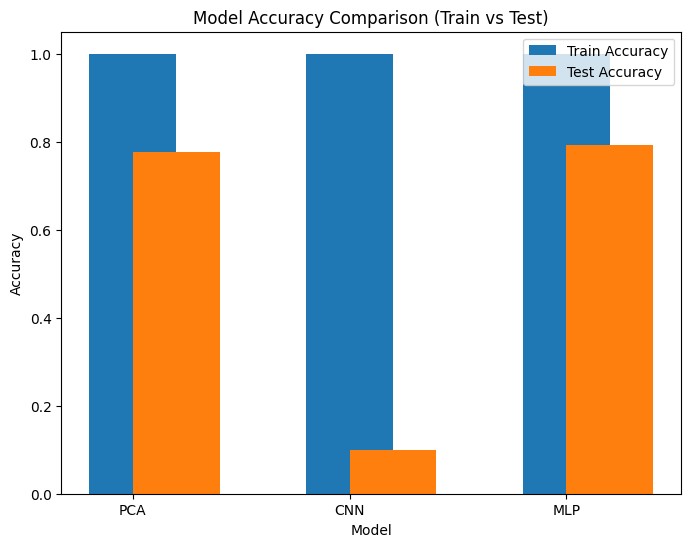

In [31]:
import matplotlib.pyplot as plt

# Function to calculate accuracy manually
def calculate_accuracy(predictions, true_labels):
    correct = (predictions == true_labels).sum().item()  # Count the correct predictions
    total = true_labels.shape[0]  # Total number of labels (using shape[0])
    return correct / total  # Return accuracy as a fraction

# Calculate accuracy for PCA model
PCA_train_accuracy = calculate_accuracy(PCApredictions_train, y_train)
PCA_test_accuracy = calculate_accuracy(PCApredictions_test, y_test)

# Calculate accuracy for CNN model
CNN_train_accuracy = calculate_accuracy(CNNpredictions_train, y_train)
CNN_test_accuracy = calculate_accuracy(CNNpredictions_test, y_test)

# Calculate accuracy for MLP model
MLP_train_accuracy = calculate_accuracy(MLPpredictions_train, y_train)
MLP_test_accuracy = calculate_accuracy(MLPpredictions_test, y_test)

# Print the accuracies
print(f"PCA Model - Train Accuracy: {PCA_train_accuracy:.4f}, Test Accuracy: {PCA_test_accuracy:.4f}")
print(f"CNN Model - Train Accuracy: {CNN_train_accuracy:.4f}, Test Accuracy: {CNN_test_accuracy:.4f}")
print(f"MLP Model - Train Accuracy: {MLP_train_accuracy:.4f}, Test Accuracy: {MLP_test_accuracy:.4f}")

# Prepare data for plotting
models = ['PCA', 'CNN', 'MLP']
train_accuracies = [PCA_train_accuracy, CNN_train_accuracy, MLP_train_accuracy]
test_accuracies = [PCA_test_accuracy, CNN_test_accuracy, MLP_test_accuracy]

# Plotting the accuracies
x = range(len(models))
plt.figure(figsize=(8, 6))

# Plot train and test accuracies
plt.bar(x, train_accuracies, width=0.4, label='Train Accuracy', align='center')
plt.bar(x, test_accuracies, width=0.4, label='Test Accuracy', align='edge')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (Train vs Test)')
plt.xticks(x, models)
plt.legend()

# Display the plot
plt.show()


### 2.

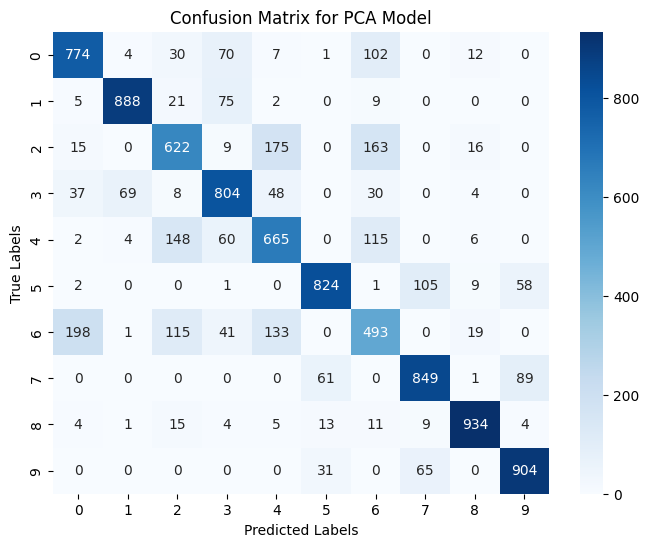

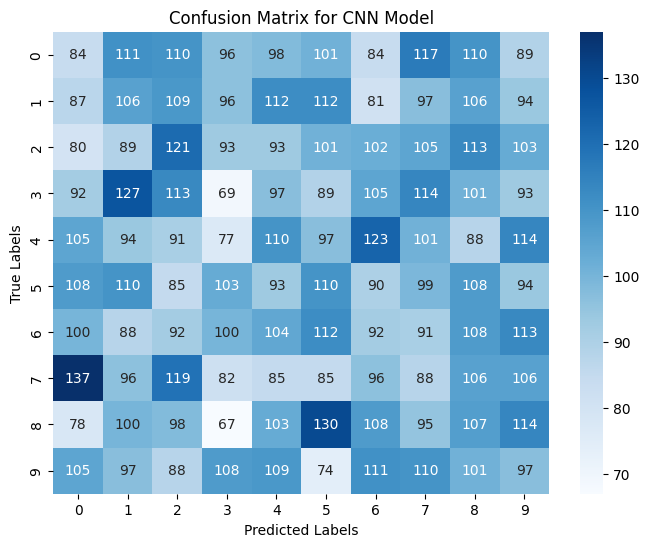

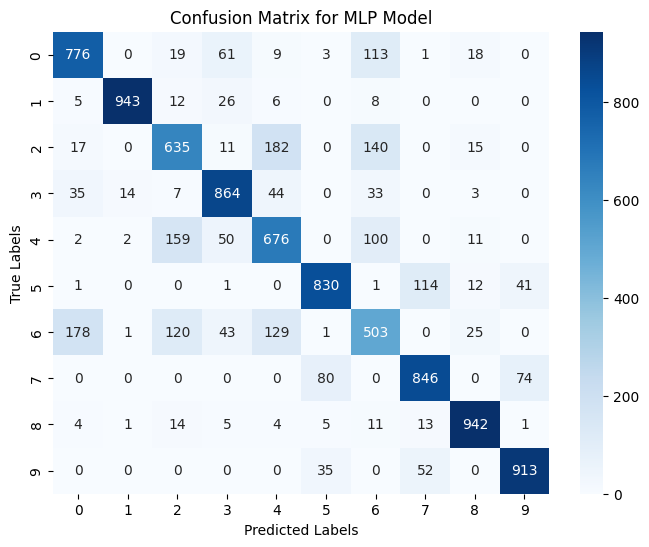

In [28]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, num_classes=10):
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot confusion matrix for PCA model
plot_confusion_matrix(y_test, PCApredictions_test, model_name="PCA Model")

# Plot confusion matrix for CNN model
plot_confusion_matrix(y_test, CNNpredictions_test, model_name="CNN Model")

# Plot confusion matrix for MLP model
plot_confusion_matrix(y_test, MLPpredictions_test, model_name="MLP Model")


### Similar Performance Classes:
- **Class 1, 8, and 9**: All models (CNN, MLP, PCA) show strong performance, especially for Class 1 and Class 8, where accuracies are consistently above 90%.

### Model-Specific Observations:
- **PCA**: Strong diagonal dominance, best on Class 8 (934/1000) and 9 (904/1000), with confusion between Class 6 and 0.
- **CNN**: Lower accuracy, more evenly distributed errors across all classes, and generally performs worse than PCA and MLP.
- **MLP**: Similar to PCA, best on Class 1 (943/1000), with confusion patterns similar to PCA, especially for Class 6 and 0.

### Key Differences:
- **CNN**: More distributed errors, whereas PCA and MLP have concentrated confusion (Class 6 vs. 0).
- **PCA and MLP**: Show similar performance and confusion patterns, outperforming CNN.

### Conclusion:
- **Class 8 and 9** show similar strong performance across all models. PCA and MLP generally outperform CNN, especially for Classes 1 and 8. CNN's performance is more balanced but lower in accuracy.
